#### Filtering US dataframe into DC

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import itertools
from itertools import combinations
from scipy import spatial
import pickle as pickle
import gudhi
from pylab import *
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import seaborn as sns
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from matplotlib import pyplot
import warnings

# Ignore FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# imoporting SVI data for the entire US(county level) 
us_svi = gpd.read_file('../data/processed data/SVI 2018 with HepVu/SVI2018_US_county_with_opioid_indicators.shp')

In [4]:
# include only the Washington DC, Virginia, Maryland, and West Virginia(county level)
filtered_svi_df = us_svi[us_svi['ST_ABBR'].isin(['VA', 'MD', 'WV', 'DC'])]

In [5]:
# reset index
filtered_svi_df.reset_index(drop=True, inplace=True)

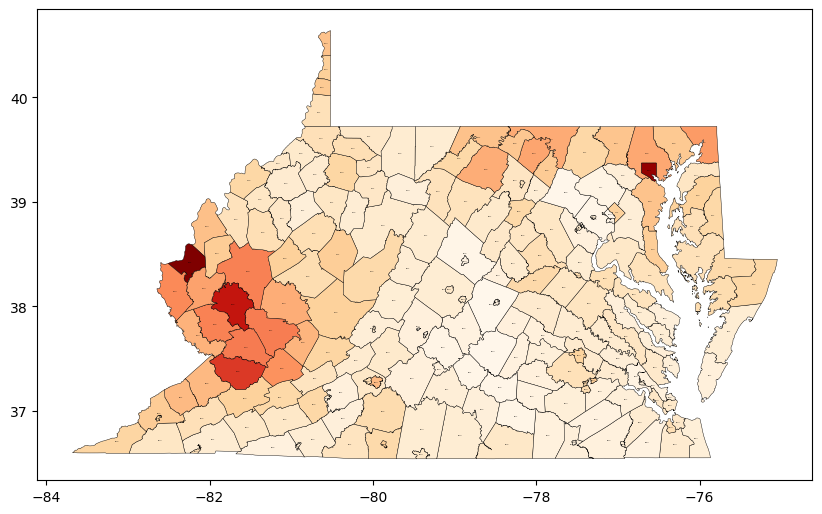

In [6]:
# Plot the data for the Washington DC, Virginia, Maryland, and West Virginia(county level)
ax = filtered_svi_df.plot(figsize=(10, 10), column="NOD_Rate", legend=False, cmap='OrRd', edgecolor='black',linewidth=0.3)

for idx, row in filtered_svi_df.iterrows():
    centroid = row.geometry.centroid
    county_name = row.FIPS
    ax.annotate(text=county_name, xy=(centroid.x, centroid.y), ha='center', fontsize=0.5)

# Display the plot
plt.show()

In [11]:
# checking the data type of the FIPS column
print(type(filtered_svi_df['FIPS'][0]))

<class 'str'>


##### Now I need to extract specifically Washington DC Metropolitan Area SVI dataset.

In [7]:
# this contais Washington DC Metro area counties(shapefile)
metro_map_df = gpd.read_file('./data/DC_Metro_counties/Washington_Arlington_Alexandria_DC_VA_MD_WV_Counties.shp')

In [8]:
metro_map_df.head(3)

,OBJECTID,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,...,Shape_Area,CBSAFP,METDIVFP,CSAFP,CBSA_Title,M_Status,MDIV_Title,CSA_Title,C_Status,geometry
0,734,54,037,01550025,54037,Jefferson,Jefferson County,06,H1,G4020,...,0.057252,47900,47894,548,"Washington-Arlington-Alexandria, DC-VA-MD-WV",Metropolitan Statistical Area,"Washington-Arlington-Alexandria, DC-VA-MD-WV","Washington-Baltimore-Arlington, DC-MD-VA-WV-PA",Outlying,"POLYGON ((-78.03541 39.27841, -78.03526 39.278..."
1,1266,24,009,01676636,24009,Calvert,Calvert County,06,H1,G4020,...,0.092340,47900,47894,548,"Washington-Arlington-Alexandria, DC-VA-MD-WV",Metropolitan Statistical Area,"Washington-Arlington-Alexandria, DC-VA-MD-WV","Washington-Baltimore-Arlington, DC-MD-VA-WV-PA",Outlying,"POLYGON ((-76.56813 38.40771, -76.57181 38.408..."
2,1297,24,033,01714670,24033,Prince George's,Prince George's County,06,H1,G4020,...,0.134028,47900,47894,548,"Washington-Arlington-Alexandria, DC-VA-MD-WV",Metropolitan Statistical Area,"Washington-Arlington-Alexandria, DC-VA-MD-WV","Washington-Baltimore-Arlington, DC-MD-VA-WV-PA",Central,"POLYGON ((-77.04202 38.74672, -77.04191 38.750..."


In [13]:
# checking the data type of the GEO ID column
print(type(metro_map_df['GEOID'][0]))

<class 'str'>


In [9]:
# In the metro shapefile GEOID contains the FIPS code
# metro_svi_deaths will contains SVI and fatalities data for the Washington DC Metro area counties
metro_svi_hepvu = filtered_svi_df[filtered_svi_df['FIPS'].isin(metro_map_df['GEOID'].tolist())]
metro_svi_hepvu.reset_index(drop=True, inplace=True)

In [10]:
metro_svi_hepvu.head(3)

,ST,STATE,ST_ABBR,COUNTY,FIPS,LOCATION,AREA_SQMI,E_TOTPOP,M_TOTPOP,E_HU,...,F_THEME4,F_TOTAL,E_UNINSUR,M_UNINSUR,EP_UNINSUR,MP_UNINSUR,E_DAYPOP,GEO ID,NOD_Rate,geometry
0,24,MARYLAND,MD,Calvert,24009,"Calvert County, Maryland",213.190902,91082,0,35003,...,0,0,3761,724,4.2,0.8,62807,24009,36.6,"POLYGON ((-76.70121 38.71276, -76.69914 38.715..."
1,24,MARYLAND,MD,Frederick,24021,"Frederick County, Maryland",660.468379,248472,0,95986,...,0,0,11739,1103,4.8,0.4,228950,24021,30.6,"POLYGON ((-77.67716 39.32453, -77.67637 39.330..."
2,51,VIRGINIA,VA,Clarke,51043,"Clarke County, Virginia",175.932840,14365,0,6317,...,0,0,2012,488,14.2,3.4,11139,51043,15.6,"POLYGON ((-78.15170 39.03667, -78.14240 39.061..."


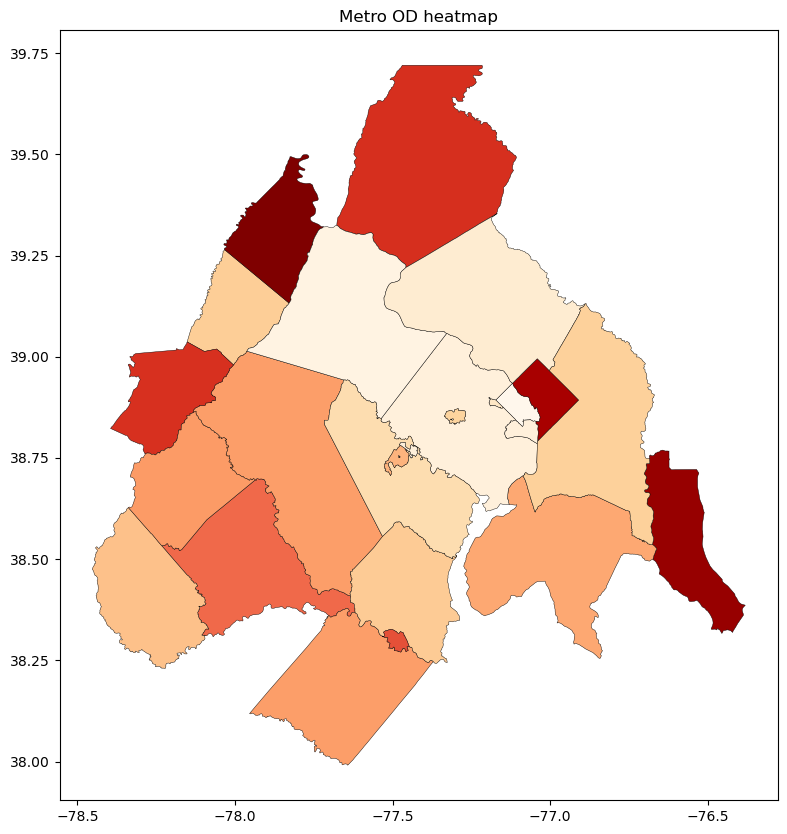

In [19]:
# Plot the data side by side using subplots
fig, axes = plt.subplots(figsize=(10, 10), nrows=1, ncols=1)

# Plot for filtered_result (assuming filtered_result is your filtered dataframe)
ax = metro_svi_hepvu.plot(ax=axes, column="NOD_Rate", legend=False, cmap='OrRd', edgecolor='black', linewidth=0.3)
ax.set_title('Metro OD heatmap')

# Display the plot
plt.show()

#### Saving dataframe to a shapefile

In [12]:
# Convert the DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(metro_svi_hepvu, geometry='geometry')

In [13]:

# Save the GeoDataFrame to a Shapefile
gdf.to_file("./data/processed data/SVI2018 DC counties with death rate HepVu/SVI2018_DC_counties_with_death_rate_HepVu.shp", driver='ESRI Shapefile')